## Portfolio Diversification
Portfolio diversification as binary polynomial optimization problem using Variational Quantum Eigensolver by formulating the problem as an Hamiltonian

- Build classical optimizer using cplex
- Build quantum optimizer using Sampling VQE, QAOA
- Compare the selection of representative stocks and the cost for both classical and quantum approaches

In [35]:
import math
import datetime
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit.library import TwoLocal
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_finance.applications.optimization import PortfolioDiversification


In [36]:
# Extract random time series data
seed = 1234
n = number_stocks = 3
q = pickable_stocks = 2 # q should be less than n
stocks = ["TICKER%s" % (i+1) for i in range(number_stocks)]
data = RandomDataProvider(tickers=stocks, start= datetime.datetime(2024, 1, 1), end=datetime.datetime(2024, 1, 30), seed=seed)
data.run()

rho = data.get_similarity_matrix() # rho is the symbol in the equation for similarity matrix



In [37]:
# Classical solution for solving the problem using IBM CPLEX
import cplex

class ClassicalOptimizer:
  def __init__(self, rho, n, q):
    self.rho = rho
    self.n = n
    self.q = q

  def get_possible_combinations(self):
    return int(math.factorial(n)/ math.factorial(q) / math.factorial(n - q))
  

  def cplex_solution(self):
    n = self.n
    rho = self.rho
    q = self.q


    # Create vector to of n(n+1) = n**2 + n elements which has the similarity matrix and all the representative stocks
    my_obj = list(rho.reshape(1, n**2)[0]) + [0 for i in range(n)] 
    my_ub = [1 for i in range(n**2 + n)]
    my_lb = [0 for i in range(n**2 + n)]
    my_ctype = "".join("I" for i in range(n**2 + n))
    my_rhs = (
      [q] + 
      [1 for x in range(n)] +
      [0 for x in range(n)] +
      [0.1 for x in range(n**2)]
    )
    my_sense = [
      "".join("E" for i in range(n+1))+
      "".join("E" for i in range(n))+
      "".join("L" for i in range(n**2))
    ]

    try:
      my_prob = cplex.Cplex()
      self.populatebyrow(my_prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs)
      my_prob.solve()
    except cplex.CplexError as e:
      print(e)
      return
    
    x = my_prob.solution.get_values()
    x = np.array(x)
    cost = my_prob.solution.get_objective_value()

    return x, cost
  
  def populatebyrow(self, prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs):
    prob.objective.set_sense(prob.objective.sense.minimize)
    prob.variables.add(obj = my_obj, lb = my_lb, ub=my_ub, types=my_ctype)
    prob.set_log_stream(None)
    prob.set_error_stream(None)
    prob.set_warning_stream(None)
    prob.set_results_stream(None)

    rows = []
    col = [x for x in range(n**2, n**2 + n)]
    coeff = [1 for x in range(n)]
    rows.append([col, coeff])

    for ii in range(self.n):
      col = [x for x in range(0+n*ii, n+n*ii)]
      coeff = [1 for x in range(n)]
      rows.append([col, coeff])

    for ii in range(self.n):
      col = [ii*n+ii, n**2 + ii]
      coeff = [1, -1]
      rows.append([col, coeff])
    
    for ii in range(0,n):
      for jj in range(0, n):
        col = [ii*n+jj, n**2 + jj]
        coeff = [1, -1]
        rows.append([col, coeff])
    prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)



In [38]:
classical_optimizer = ClassicalOptimizer(rho, n, q)
print("Number of feasible solutions:", str(classical_optimizer.get_possible_combinations()))
print("Total number of combinations:", str(2**(n*(n+1))))

Number of feasible solutions: 3
Total number of combinations: 4096


In [46]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.015, yc[i]), size=16, color="r")

    plt.grid()

    for ii in range(n**2, n**2 + n):

        if x[ii] > 0:
            plt.plot(xc[ii - n**2], yc[ii - n**2], "r*", ms=20)

    for ii in range(0, n**2):

        if x[ii] > 0:
            iy = ii // n
            ix = ii % n
            plt.plot([xc[ix], xc[iy]], [yc[ix], yc[iy]], "C2")

    plt.title(title_str + " cost = " + str(int(C * 100) / 100.0))
    plt.show()

In [40]:
from qiskit_algorithms.utils import algorithm_globals

# Implements the quantum solution using VQE and QAOA approach
class QuantumOptimizer:
  def __init__(self, rho, n, q):
    self.n = n
    self.rho = rho
    self.q = q
    self.portfolio_diversification = PortfolioDiversification(similarity_matrix=rho, num_assets=self.n, num_clusters=self.q)
    self.quad_program = self.portfolio_diversification.to_quadratic_program()
  

  def exact_solution(self):
    eigen_solver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    result = eigen_solver.solve(self.quad_program)
    return self.decode_results(result)

  def sampling_vqe_solution(self):
    algorithm_globals.random_seed = 1234
    cobyla  = COBYLA(maxiter=250)
    ry = TwoLocal(self.n, "ry", "cz", reps=5, entanglement="full")
    sampling_vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
    problem_solver = MinimumEigenOptimizer(sampling_vqe)
    result = problem_solver.solve(self.quad_program)
    return self.decode_results(result)
  
  def qaoa_solution(self):
    algorithm_globals.random_seed = 1234
    cobyla = COBYLA(maxiter=250)
    qaoa = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
    problem_solver = MinimumEigenOptimizer(qaoa)
    result = problem_solver.solve(self.quad_program)
    return self.decode_results(result)



  def decode_results(self, result):
    quantum_solution = 1 - (result.x)
    ground_level = self.quad_program.objective.evaluate(result.x)
    return quantum_solution, ground_level


    

In [41]:
quantum_optimizer = QuantumOptimizer(rho, n, q)
classical_cost = 0
# Check if binary forulation is correct (IH-QP) by comapring classical and quaantum approach
try:
  quantum_solution, quantum_cost = quantum_optimizer.exact_solution()
  print(f"Quantum Solution: {quantum_solution}, Cost: {quantum_cost}")
  classical_solution, classical_cost = classical_optimizer.cplex_solution()
  print(f"Classical Solution: {classical_solution}, Cost: {classical_cost}")
  if np.abs(classical_cost - quantum_cost) < 0.01:
    print("Binary formulation is correct")
  else:
    print("Error in formulation of hamiltonian")
except Exception as e:
  print(e)

Quantum Solution: [0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0.], Cost: 2.005306334166298
Classical Solution: [1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1.], Cost: 2.001767927912732
Binary formulation is correct


In [42]:
# Second check if ising hamiltonian is encoded properly
ground_state, ground_level_cost = quantum_optimizer.exact_solution()
print(ground_state)
if np.abs(ground_level_cost - classical_cost) < 0.01:
  print("Ising Hamiltonian in Z basis encoded properly")
else:
  print("Error in ising hamiltonian formulation")


[0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0.]
Ising Hamiltonian in Z basis encoded properly


In [57]:
vqe_state, vqe_solution = quantum_optimizer.sampling_vqe_solution()
print(f"VQE state:: {vqe_state} and solution: {vqe_solution}")
if np.linalg.norm(vqe_state - ground_state) < 0.01:
  print("VQE and exact solution are the same")
else:
  print("VQE and exact solution are not same and is expected to happen")

/var/folders/_g/pnkjprqj7z3d7wwtd6jwl2fc0000gn/T/ipykernel_3326/1170830057.py:1: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  vqe_state, vqe_solution = quantum_optimizer.sampling_vqe_solution()


VQE state:: [0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0.] and solution: 2.001767927912732
VQE and exact solution are not same and is expected to happen


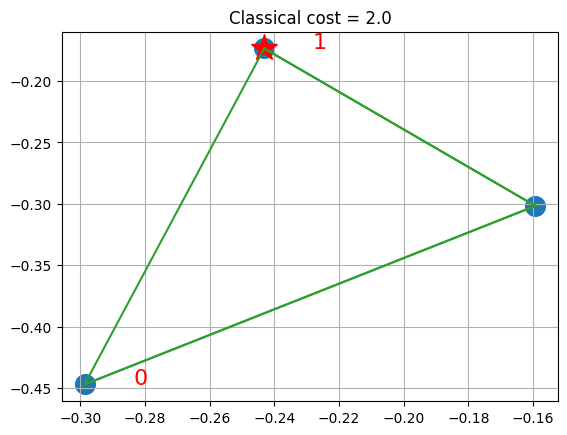

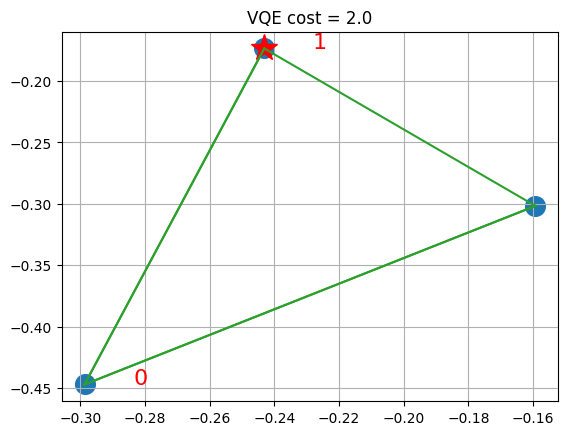

In [58]:
# Visualize the solution

xc, yc = data.get_coordinates()
visualize_solution(xc, yc, ground_state, ground_level_cost, n, q, "Classical")
visualize_solution(xc, yc, vqe_state, vqe_solution, n, q, "VQE")